# Vitesse de réponse aux crises financières et paramètres structurels des pays

## Par Saad ABDELLAOUI ANDALOUSSI MAANE & Patrick Junior HOUNKPE

### Introduction

## Sommaire

# Installation des packages

In [1]:
%pip install -r requirements.txt

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scripts import data_collector as dc
from scripts import data_cleaner as dcl
from scripts import data_analysis as da
from scripts import data_visualization as dv
from scripts import regression as rg


Note: you may need to restart the kernel to use updated packages.


# Préparation des données

# 1. Adresses de scraping utilisées

############################## TEXTE ###############################
Inclure également l'API de la WorldBank

In [2]:
landlocked_url = "https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline"
codesISO_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

# 2. Codes ISO-2 et ISO-3 relatifs aux pays

Pourquoi nous fallait-il les codes ISO des pays et pas seulement leurs noms? 

L'explication est la suivante:

- **Nettoyer les jeux de données** qui ne contiennent pas uniquement des pays, mais également des communautés géographiques, des régions sous tutelle, etc.

- **Comparer des bases de données** ne portant pas exactement sur les mêmes ensembles de pays. Uniformiser les identifiants des pays avec les codes ISO nous permettrait de réaliser des opérations de jointures sur des bases de données n'ayant pas forcément les mêmes identifiants.

Nous avons donc scrappé cette liste de codes ISO sur [Wikipédia](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes).


Par ailleurs, au cours de l'exécution du projet, nous avons fait face à un moment à une indisponibilité de la page Wikipédia. Cela nous a donc conduit à sauvegarder une version backup du fichier. Ainsi avec le code suivant nous essayons de récupérer les codes ISO directement depuis Wikipédia et si cela ne marche pas on se rabat sur la version locale sauvegardée.

In [3]:
try:
    codesISO_data = dc.get_ISOcodes(codesISO_url)
    codesISO_data = dcl.clean_ISOData(codesISO_data)
except Exception as e:
    print(f"An error occurred while fetching or cleaning ISO codes data: {e}")
    codesISO_data = pd.read_csv("data/ISO_data.csv")
    codesISO_data.drop(columns=['Unnamed: 0'], inplace=True)
    
codesISO_data

,Pays,ISO-2,ISO-3
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,Andorra,AD,AND
4,Angola,AO,AGO
...,...,...,...
188,Venezuela (Bolivarian Republic of),VE,VEN
189,Viet Nam[ak],VN,VNM
190,Yemen,YE,YEM
191,Zambia,ZM,ZMB


# 3. PIB Réel

Notre variable d’intérêt ici est le PIB réel, qui mesure la valeur de la production de biens et de services d’un pays corrigée des variations de prix.

Quelle est donc l'utilité du PIB Réel comparativement au PIB nominal?

- Contrairement au PIB nominal, le PIB réel permet de comparer les niveaux de production dans le temps et entre pays en *neutralisant l’effet de l’inflation*.
- Il est exprimé à *prix constants*, généralement par référence à une année de base. 

De fait, le PIB réel constitue ainsi un indicateur de l’activité économique et du niveau de richesse réellement produit par une économie.


Dans la suite, nous avons créé une fonction dans le dossier `scripts` qui permet de se connecter à l'API de la [World Bank](https://data.worldbank.org/) pour récupérer des données sur les indicateurs de nos choix concernant certains pays de nos choix. Une fois les données récupérées nous les structurons afin de faciliter les analyses à posteriori.

En l'occurence ici, nous récupérons les données du PIB Réel entre 1990 et 2024 sur les pays contenus dans la liste des codes ISO précédemment chargés.

In [4]:
worldBank = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
PIB_Reel_data = worldBank.get_indicator("PIB", liste_pays, start=1990, end=2024)
PIB_Reel_data

,country,date,PIB
0,Afghanistan,2024,NaN
1,Afghanistan,2023,1.567265e+10
2,Afghanistan,2022,1.532523e+10
3,Afghanistan,2021,1.634520e+10
4,Afghanistan,2020,2.062196e+10
...,...,...,...
6750,Zimbabwe,1994,1.776635e+10
6751,Zimbabwe,1993,1.626430e+10
6752,Zimbabwe,1992,1.609508e+10
6753,Zimbabwe,1991,1.768993e+10


Par la suite, notre objectif était d'assigner à la matrice des données du PIB Réel une correspondance entre le nom en toutes lettres du pays et son code ISO. Dans ce processus, nous remarquons qu'il y a des problèmes avec les correspondances de noms entre les codes ISO et les noms des pays dans le dataframe `PIB_reel_data`. 

Un exemple de problème est le suivant:

Dans le dataframe `codesISO_data` des codes ISO, il y a des caractères indésirables au niveau des noms de certains pays (Viet Nam[ak], Venezuela (Bolivarian Republic of),...). Cela peut donc causer des problèmes lorsqu'on essaye de faire un matching entre ces pays et ceux contenus dans le dataframe `PIB_Reel_data`. 

Pour donc palier à cela nous avons développé un algorithme sur les chaînes de caractères qui permet de supprimer les caractères indésirables et de réaliser le matching entre les pays et leurs codes ISO.

In [5]:
PIB_countries = set(PIB_Reel_data["country"].unique())
ISO_countries = set(codesISO_data["Pays"].unique())

matching_dictionnary = {}

# Récupérer les pays avec un seul mot dans leur nom
single_word_countries = set(PIB_Reel_data[PIB_Reel_data['country'].str.split().str.len() == 1]['country'].tolist())
ISO_complicated_word_countries = ISO_countries 
potential_matching_complicated_word_countries = PIB_countries 

# Premier algorithme de matching basé sur les pays où les noms n'ont pas des caractères bizarres mais juste plusieurs mots
solved_ISO_complicated_word_countries = set()
solved_potential_matching_word_countries = set()

for iso_country in ISO_complicated_word_countries:
    for pib_country in potential_matching_complicated_word_countries:
        if iso_country in pib_country or pib_country in iso_country:
            matching_dictionnary[pib_country] = iso_country
            solved_ISO_complicated_word_countries.add(iso_country)
            solved_potential_matching_word_countries.add(pib_country)
            

# Afficher les pays non résolus après le premier algorithme
unresolved_ISO_countries = ISO_complicated_word_countries - solved_ISO_complicated_word_countries
unresolved_potential_matching_countries = potential_matching_complicated_word_countries - solved_potential_matching_word_countries

# Résoudre les derniers problèmes

for pib_country in unresolved_potential_matching_countries:
    for iso_country in unresolved_ISO_countries:
        # Je n'ai pas besoin des caractères après la virgule pour les pays problématiques.
        pib_country = pib_country.split(',')[0]
        
        if pib_country[:5] == iso_country[:5]:
            matching_dictionnary[pib_country] = iso_country
            break
        
# Résoudre les problèmes d'autres pays déviants manuellement
          
matching_dictionnary['Congo, Dem. Rep.'] = 'Congo (the Democratic Republic of the)'
matching_dictionnary['Congo, Rep.'] = 'Congo (the)[k]'
matching_dictionnary['Turkiye'] = 'Türkiye[ag]'
matching_dictionnary['Korea, Rep.'] = 'Korea (the Republic of)[u]'
matching_dictionnary['Korea, Dem. People\'s Rep.'] = 'Korea (the Democratic People\'s Republic of)[t]'
matching_dictionnary['Venezuela, RB'] = 'Venezuela (Bolivarian Republic of)'

En quoi consiste cet algorithme?

1. Il repose en premier lieu sur une comparaison textuelle simple. On associe de manière automatique les pays dont les noms se contiennent partiellement (Par exemple comme 'Viet Nam' est contenu dans 'Viet Nam[ak]', on associe ces deux chaînes de caractères). Les pays ainsi appariés sont ensuite exclus des listes afin d’identifier les cas non résolus.

2. Pour les pays restants, une seconde règle est appliquée en supprimant les informations secondaires (notamment les caractères suivant une virgule) et en comparant les premiers caractères des noms. Cette règle est appliquée car nous avons remarqué que dans la base de données, après le nom de certains pays, des informations sur le caractère fédéral ou démocratique du pays est inclus. Cela ne nous intéresse pas ici donc on s'en passe.

3. Enfin, les quelques cas particuliers présentant des divergences importantes de dénomination sont corrigés manuellement afin de garantir une correspondance complète et cohérente entre les deux bases.


Une fois que nous avons créé l'algorithme, nous créons la structure de données (ici un dictionnaire) qui permet de faire le matching des pays et de leurs codes ISO.

In [6]:
# Matcher maintenant les pays aux ISO

ISO_matching_dictionnary = {}
for i in range(len(codesISO_data)):
    line = codesISO_data.iloc[i]
    ISO_matching_dictionnary[line["Pays"]] = line["ISO-3"]

for key in matching_dictionnary.keys():
    matching_dictionnary[key] = ISO_matching_dictionnary[matching_dictionnary[key]]
    
matching_dictionnary

{'Sri Lanka': 'LKA',
 'Uganda': 'UGA',
 'Albania': 'ALB',
 'Chad': 'TCD',
 'Algeria': 'DZA',
 'Lithuania': 'LTU',
 'Yemen, Rep.': 'YEM',
 'Guinea': 'PNG',
 'Guinea-Bissau': 'GNB',
 'Equatorial Guinea': 'GNQ',
 'Papua New Guinea': 'PNG',
 'Nepal': 'NPL',
 'Portugal': 'PRT',
 'Seychelles': 'SYC',
 'Finland': 'FIN',
 'Fiji': 'FJI',
 'Bhutan': 'BTN',
 'Tajikistan': 'TJK',
 'Namibia': 'NAM',
 'Malawi': 'MWI',
 'Madagascar': 'MDG',
 'Singapore': 'SGP',
 'Bolivia': 'BOL',
 'Israel': 'ISR',
 'Belize': 'BLZ',
 'France': 'FRA',
 'Mauritania': 'MRT',
 'Liechtenstein': 'LIE',
 'Timor-Leste': 'TLS',
 'Moldova': 'MDA',
 'Saudi Arabia': 'SAU',
 'Thailand': 'THA',
 'Iraq': 'IRQ',
 'Mauritius': 'MUS',
 'Libya': 'LBY',
 'Brazil': 'BRA',
 'China': 'CHN',
 'El Salvador': 'SLV',
 'Iceland': 'ISL',
 'Netherlands': 'NLD',
 'Somalia, Fed. Rep.': 'SOM',
 'Paraguay': 'PRY',
 'Canada': 'CAN',
 'Vanuatu': 'VUT',
 'Argentina': 'ARG',
 'Brunei Darussalam': 'BRN',
 'Oman': 'OMN',
 'India': 'IND',
 'Kazakhstan': 'KAZ

Nous réalisons maintenant l'assignation des codes ISO et nous vérifions s'il n'y a pas des erreurs.

In [7]:
PIB_Reel_data["country"] = PIB_Reel_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
PIB_Reel_data

,country,date,PIB
0,AFG,2024,NaN
1,AFG,2023,1.567265e+10
2,AFG,2022,1.532523e+10
3,AFG,2021,1.634520e+10
4,AFG,2020,2.062196e+10
...,...,...,...
6750,ZWE,1994,1.776635e+10
6751,ZWE,1993,1.626430e+10
6752,ZWE,1992,1.609508e+10
6753,ZWE,1991,1.768993e+10


# Valeurs manquantes

Ici, nous procédons à une vérification de la qualité et de l'intégrité des données que nous avons récupéré via l'API.

In [8]:
da.check_missing_values(PIB_Reel_data,"PIB")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 178 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 2.64% de valeurs manquantes dans la base de données.



On remarque donc qu'il y a des valeurs manquantes dans notre dataframe. Nous devons donc trouver un moyen de régler ce problème. En premier lieu, on va essayer de localiser où se trouvent ces valeurs manquantes dans la base de données.

Deux pistes peuvent être explorées:
1. Soit les valeurs manquantes proviennent de dates spécifiques.
2. Soit elles proviennent de pays spécifiques.

Explorons d'abord la première piste relative aux dates. Pour ce faire nous observons la répartition des valeurs manquantes par année.

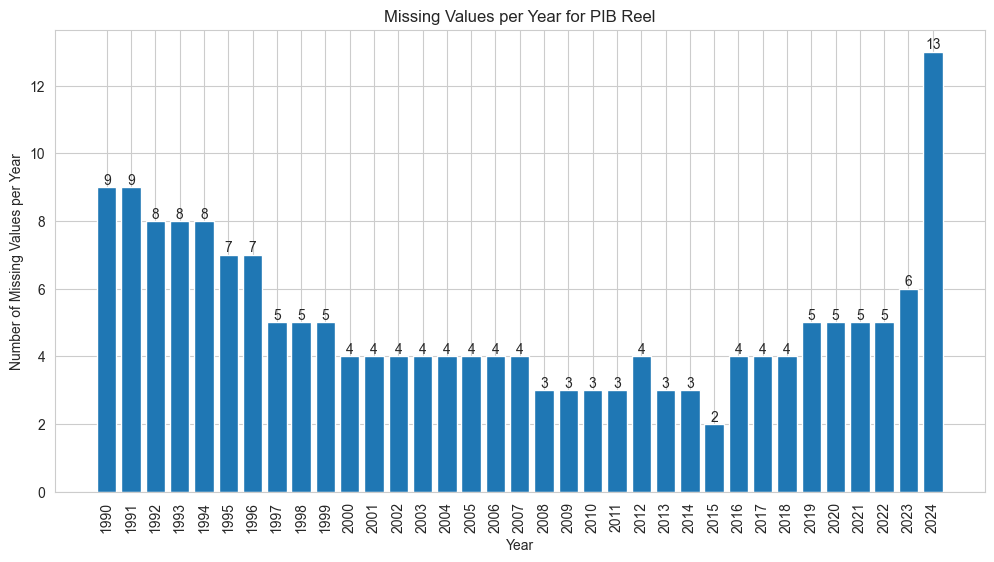

In [9]:
dv.plot_missing_values_per_year(PIB_Reel_data,"PIB")

On remarque que la distribution des NaN est à peu près uniforme. On aurait pu conjecturer que autour des années 1990, il y aurait plus de NaN et que ce nombre diminuerait au fil du temps (grâce à la démocratisation des données). 

Mais ce n'est pas le cas ici. On remarque même un pic de données manquantes en 2024.

Essayons de voir un peu ce qui cloche en 2024 parce que c'est un phénomène étrange qu'il y ait autant de trous à une date aussi récente.

On examine donc dans la suite les pays qui ont des valeurs manquantes en 2024.

In [10]:
NaN2024 = PIB_Reel_data[PIB_Reel_data["date"]==2024]["PIB"].isna()
NaN2024_countries = PIB_Reel_data[PIB_Reel_data["date"]==2024][NaN2024]
NaN2024_countries

# faire un commentaire
# Ce qu'on peut probablement faire c'est de l'imputation de données manquantes en utilisant la moyenne des valeurs des années précédentes pour chaque pays.
# Mais cela ne peut se faire que si on est dans des années qui sont intérieures c'est-à dire à partir de la première année omù il n'y a pas de valeur manquante

,country,date,PIB
0,AFG,2024,NaN
910,BTN,2024,NaN
1820,ERI,2024,NaN
3360,LBN,2024,NaN
3500,LIE,2024,NaN
4830,PLW,2024,NaN
4935,PRK,2024,NaN
5425,SMR,2024,NaN
5530,SSD,2024,NaN
5810,SYR,2024,NaN


Une stratégie envisageable pour traiter les valeurs manquantes consiste à imputer ces données en utilisant la moyenne des valeurs observées au cours des années précédentes pour chaque pays. 

Mais, cette méthode ne peut être appliquée que pour les années intérieures, c’est-à-dire à partir de la première année pour laquelle une valeur non manquante est disponible.

Les périodes initiales présentant des données absentes ne peuvent pas être imputées de manière fiable selon cette approche. 

Mais avant de commencer l'imputation, analysons les données manquantes à la lumière du deuxième axe: celui des pays.

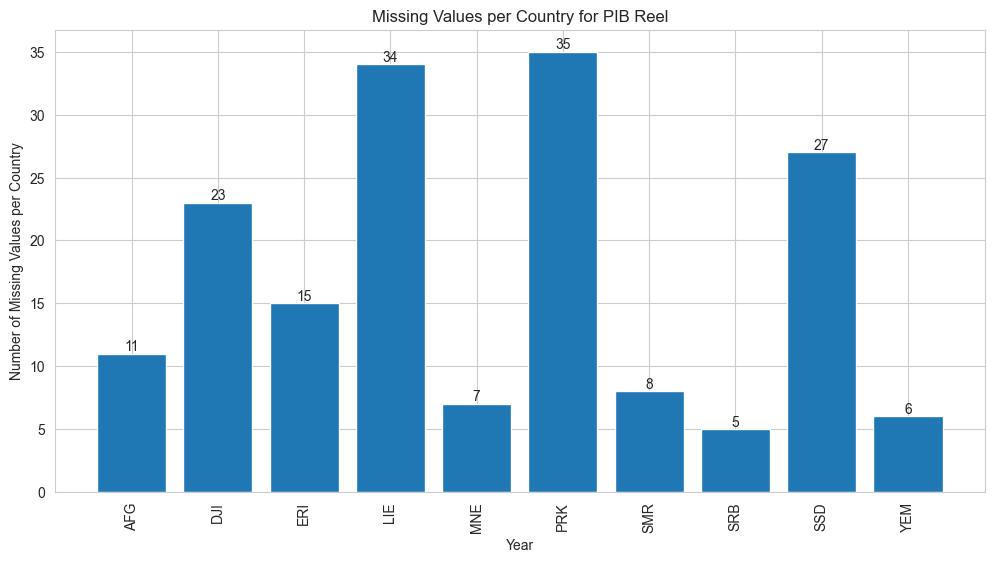

In [11]:
# Missing data per countries
# On va mettre un treshold à 5 valeurs pour tolérer 10% de données manquantes sinon on vire le pays.
countries_toRemove = dv.plot_missing_values_per_country(PIB_Reel_data,"PIB",treshold=0.1)

indexes_toRemove = []
for country in countries_toRemove:
    country_indexes = PIB_Reel_data[PIB_Reel_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

Nous avons filtré les pays avec un seuil à ***10%*** de valeurs manquantes par rapport au nombre total de valeurs possibles. Notons que ce choix de seuil était plutôt arbitraire.

Ce qu'on remarque en premier lieu c'est qu'il y a des pays qui ont la quasi-totalité de leurs informations qui sont manquantes. Cela suggère donc qu'il y a dû y avoir un problème avec les valeurs de ces pays dans les données récupérées au niveau de l'API. Nous décidonc donc d'enlever ces pays de la base de données. 

Etudions donc l'effet de l'éviction de ces pays sur les valeurs manquantes dans la base de données.

In [12]:
da.check_missing_values(PIB_Reel_data,"PIB")

PIB_Reel_data_cleaned = PIB_Reel_data.drop(indexes_toRemove,axis='index')
PIB_Reel_data_cleaned.reset_index(drop=True,inplace=True)

da.check_missing_values(PIB_Reel_data_cleaned,"PIB")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 178 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 2.64% de valeurs manquantes dans la base de données.

Le dataframe contient des données temporelles relatives à 179 pays de 1990 à 2024.
Il y a 7 valeurs manquantes sur un total de 6370 dans la base de données.
Soit un ratio de 0.11% de valeurs manquantes dans la base de données.



Le résultat est poignant. On constate une imposante réduction du ratio de valeurs manquantes en partant de `2.64%` pour atteindre `0.11%`.

Maintenant nous allons pouvoir appliquer notre stratégie d'imputation sur les valeurs manquantes qui sont toujours présentes dans le dataframe.

Regardons d'abord où elles se trouvent.

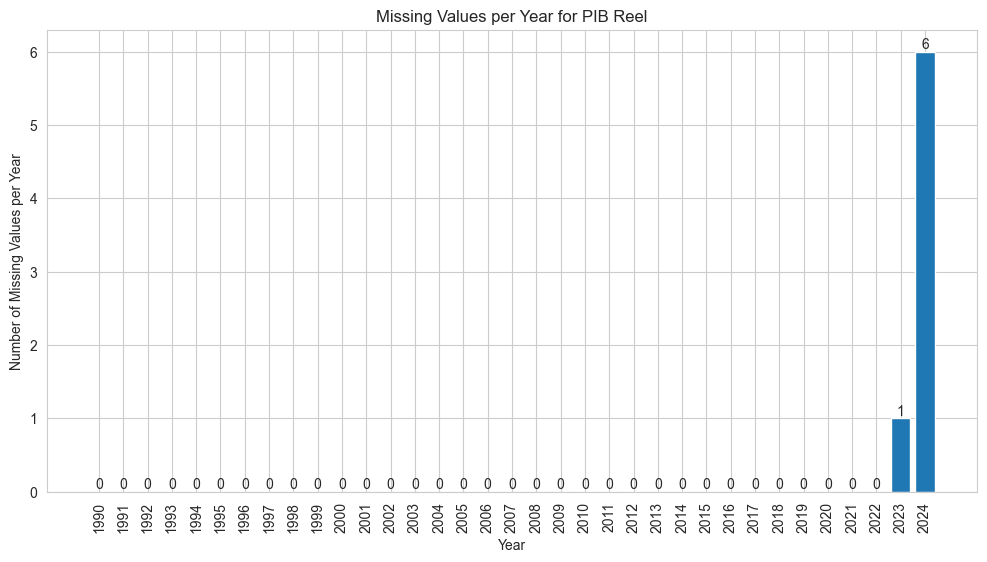

In [13]:
dv.plot_missing_values_per_year(PIB_Reel_data_cleaned,"PIB")

On remarque maintenant que les valeurs manquantes sont rares et situées à la fin de la série temporelle. Il nous apparaît donc logique de remplir ces données manquantes avec la moyenne obtenues à partir de toutes les autres valeurs. Et c'est ce que nous faisons avec les fonctions qui suivent.

In [14]:
PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
da.check_missing_values(PIB_Reel_data_final,"PIB")
PIB_Reel_data_final

Le dataframe contient des données temporelles relatives à 179 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 6370 dans la base de données.
Soit un ratio de 0.00% de valeurs manquantes dans la base de données.



,country,date,PIB
0,AGO,2024,1.078033e+11
1,AGO,2023,1.032363e+11
2,AGO,2022,1.019483e+11
3,AGO,2021,9.782408e+10
4,AGO,2020,9.580944e+10
...,...,...,...
6365,ZWE,1994,1.776635e+10
6366,ZWE,1993,1.626430e+10
6367,ZWE,1992,1.609508e+10
6368,ZWE,1991,1.768993e+10


Grâce à cette méthode nous parvenons enfin à obtenir un dataframe propre qui nous permettra d'effectuer maintenant des analyses convenables.

## Description du PIB Réel

## Evolution du PIB mondial

Tout d'abord, nous affichons une évolution du PIB mondial pour voir s'il est bien en accord avec le consensus général.

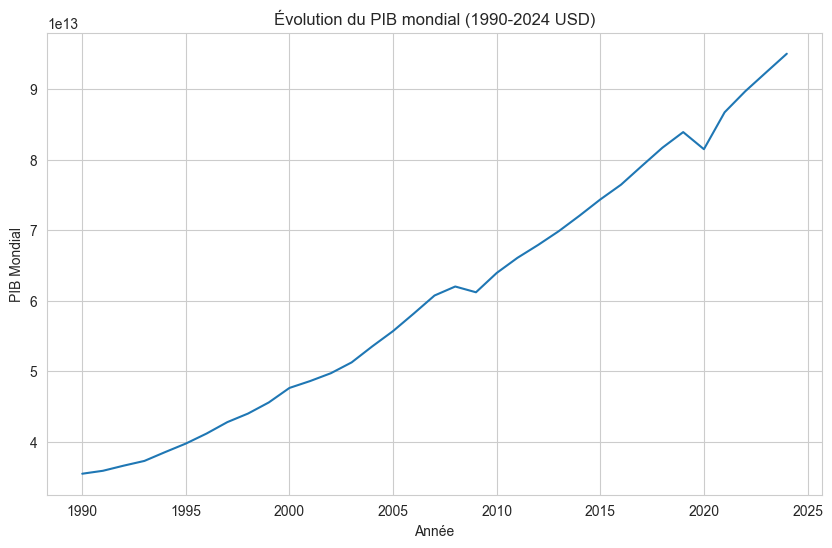

In [15]:
dv.plot_world_PIB(PIB_Reel_data_final)

On observe ainsi la croissance du PIB mondial. Cette croissance présente une dynamique positive sur le long terme, mais parfois il peut y arriver des phases de ralentissement liées à des crises économiques, financières ou sanitaires. Il apparaît donc relativement important d'étudier ces scénarios de crise afin d’interpréter correctement les variations de la tendance de long terme.

# Analyse des PIB de pays par quartiles 

Observons ensuite les évolutions par quartiles des PIB réels. Le but de cette approche est de voir si certains pays se distinguent par rapport aux autres. Pour réaliser cela, nous utilisons une séparation en 20-quantiles car visuellement, c'est la valeur qui permet d'effectuer une séparation nette des trajectoires intéressantes.

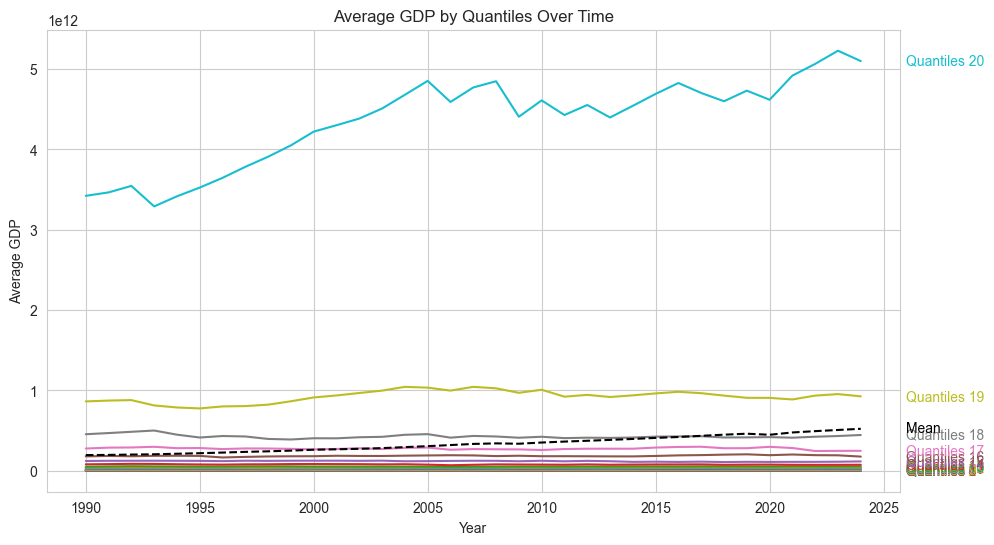

In [16]:
dv.plot_PIB_quantile(PIB_Reel_data_final)

On observe des évolutions distinctes du PIB réel par pays, avec une majorité de pays affichant des progressions continues. Notamment on arrivent à identifier deux groupes de pays qui se distinguent des autres. Intéressons nous donc à ces pays.

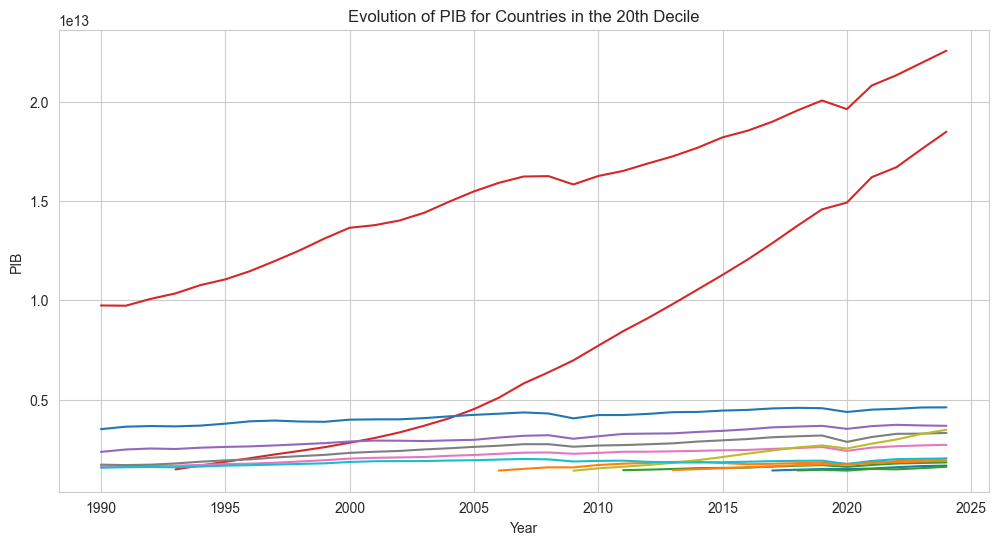

Countries in the 20th-decile: ['AUS' 'BRA' 'CAN' 'CHN' 'DEU' 'ESP' 'FRA' 'GBR' 'IND' 'ITA' 'JPN' 'KOR'
 'RUS' 'USA']


In [17]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final)

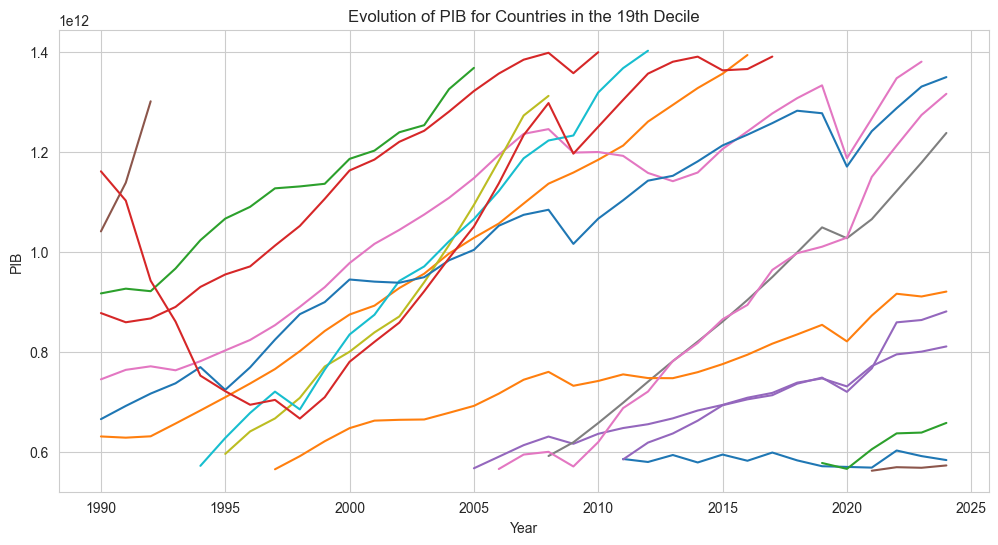

Countries in the 19th-decile: ['ARG' 'AUS' 'BRA' 'CAN' 'CHE' 'CHN' 'ESP' 'IDN' 'IND' 'KOR' 'MEX' 'NLD'
 'POL' 'RUS' 'SAU' 'SWE' 'TUR']


In [18]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final,chosen_quantile=18)

On note que dans le quantile le plus élevé (le vingtième), on retrouve des pays à forte croissance ou à grande puissance économique, tels que la France, le Brésil, le Canada, la Chine, l’Allemagne, les États-Unis, etc. Ces pays présentent des trajectoires soutenues, caractérisées par des niveaux très élevés de production économique.

Le quantile immédiatement inférieur comprend également des pays majeurs comme l’Argentine, l’Espagne, l’Indonésie, l’Inde, la Corée du Sud, la Suède et la Turquie, etc. Bien que légèrement moins performants que ceux du décile supérieur, ces pays montrent néanmoins des trajectoires économiques robustes, ce qui reflète leur rôle important dans l’économie mondiale. 

Ce qu'on retient de cette classification par quantiles c'est qu'elle permet de retrouver des résultats qui sont connus et acceptés par tous. Les pays leaders en matière de PIB réel ont donc pu être identifiés et cela fait sens.

# Ajout de la variable symbolisant la taille du pays dans l'économie mondiale

De ce qui précède, on note qu'on peut classifier les pays en termes de performances économiques. Pour faire cela, nous décidons d'introduire une nouvelle variable indicatrice de la taille d'un pays dans l'économie mondiale. Les fonctions suivantes permettent de réaliser cela en notant que la taille d'un pays est donnée en pourcentage par :

$Taille = \frac{PIB_{reel}}{PIB_{mondial}} \times 100$.


In [19]:
dump = PIB_Reel_data_final.groupby(['country','date']).sum().apply(lambda x: 100*x/PIB_Reel_data_final.groupby("date")["PIB"].sum()).reset_index() # Associer à chaque pays son poids dans l'économie mondiale par année
dump.rename(columns={"PIB":"weightCountry"},inplace=True)
weightCountry = dump.groupby(['country']).mean()['weightCountry'].reset_index() 
weightCountry.rename(columns={"weightCountry":"avgWeightCountry"},inplace=True)

weightCountry.sort_values(by="avgWeightCountry",ascending=False)
dump

,country,date,weightCountry
0,AGO,1990,0.087757
1,AGO,1991,0.087593
2,AGO,1992,0.080842
3,AGO,1993,0.060344
4,AGO,1994,0.059165
...,...,...,...
6260,ZWE,2020,0.023458
6261,ZWE,2021,0.023908
6262,ZWE,2022,0.024529
6263,ZWE,2023,0.025097


On obtient donc le dataframe suivant qui nous montre que les USA sont largement puissants avec ***26.23%*** suivis de la Chine avec ***10.52%***.

# Clustering

Nous avons appliqué l'algorithme de k-means pour classifier les pays en fonction de leur PIB réel, en fixant le nombre de clusters à 4 de manière empirique. Cette valeur permet d’isoler visuellement les groupes les plus significatifs et d’éviter de regrouper des groupes trop proches. 

On peut intuitivement dire que les clusters identifiés correspondent à quatre catégories de performance économique : Très Bas, Bas, Haut et Très Haut.

En premier lieu, on affiche une classification des pays suivant les différentes années et ensuite on affiche une classification selon la performance moyenne affichée sur toutes les années.

In [20]:
dv.animated_economicPower_map(dump)

In [21]:
clusters_EconomicPower = dv.visualize_economicPower_clusters(weightCountry)

Nous pensons que mesurer le temps de reprise des pays après une crise constitue un outil pertinent pour évaluer la robustesse économique. En mesurant la durée nécessaire à un pays pour retrouver son niveau de production ou de PIB antérieur à la crise, il permet de comparer la capacité des différentes économies à absorber les chocs et à se stabiliser. 

Pour obtenir cet indicateur nous développons l'algorithme ci-dessous.

Cet algorithme calcule le temps moyen nécessaire pour qu'un pays retrouve son niveau de PIB après un pic économique, c’est-à-dire après avoir atteint un maximum local. Il identifie d’abord les pics locaux dans la série temporelle du PIB, puis mesure, pour chaque pic, le nombre d’années nécessaires pour que le PIB dépasse à nouveau ce niveau. 

Enfin, il calcule la moyenne de ces durées, fournissant un indicateur grossier de la rapidité de reprise d’un pays après des ralentissements ou des crises.

In [22]:
def peak_to_breach_times(df_country):

    # Ordonner le dataframe pour que les séries temporelles commencent avec des dates croissantes
    df = df_country.sort_values('date').reset_index(drop=True).copy()
    
    df['prev_pib'] = df['PIB'].shift(1)
    df['next_pib'] = df['PIB'].shift(-1)
    df['is_peak'] = (df['PIB'] > df['prev_pib']) & (df['PIB'] > df['next_pib']) # Identifier les pics locaux i.e les années où le PIB est plus élevé que l'année précédente et l'année suivante
    
    peak_indices = df.index[df['is_peak']].tolist()
    
    times = []
    
    for i in peak_indices:
        peak_year = df.loc[i, 'date']
        peak_val = df.loc[i, 'PIB']
        
        # données survenues après le pic
        after_thePeak = df.loc[i+1:].copy()
        if after_thePeak.empty:
            continue
        
        # Si aucune valeur dans la suite n'est inférieure au pic, on continue parce que ça veut dire qu'il n'y a pas eu de crise après ce pic 
        if not (after_thePeak['PIB'] < peak_val).any():
            continue
        
        # Sinon on cherche la première année où le PIB dépasse le pic pour signaler un retour à la normale
        breached = after_thePeak[after_thePeak['PIB'] > peak_val]
        if breached.empty:
            continue
        
        breach_year = breached['date'].iloc[0]
        time_to_breach = breach_year - peak_year
        times.append(time_to_breach)
    
    mean_time = np.mean(times) if len(times) > 0 else np.nan # Permet de calculer un cas moyen
    return mean_time


responseTime_data = pd.DataFrame(PIB_Reel_data_final.groupby('country')[['date','PIB']].apply(lambda x:np.log(peak_to_breach_times(x))))
responseTime_data.rename(columns={0:"avgResponseTime"},inplace=True)
responseTime_data.reset_index(inplace=True)

responseTime_data.sort_values(by="avgResponseTime",ascending=False)

,country,avgResponseTime
33,COD,2.397895
178,ZWE,2.374906
76,ITA,2.079442
2,AND,1.992430
0,AGO,1.945910
...,...,...
166,TZA,NaN
167,UGA,NaN
168,UKR,NaN
171,UZB,NaN


Nous remarquons de fait qu'il y a des valeurs manquantes pour certains pays. Cela se traduit probablement par le fait que sur les séries temporelles relatives à certains pays, il n'y a pas assez de fluctuations ce qui ne permet pas de récupérer des temps de réponses aux crises. 

Analysons plus en profondeur la répartition de ces valeurs manquantes.

In [23]:
da.check_missing_values(responseTime_data,"avgResponseTime")

Il y a 17 valeurs manquantes sur un total de 179 dans la base de données.
Soit un ratio de 9.50% de valeurs manquantes dans la base de données.



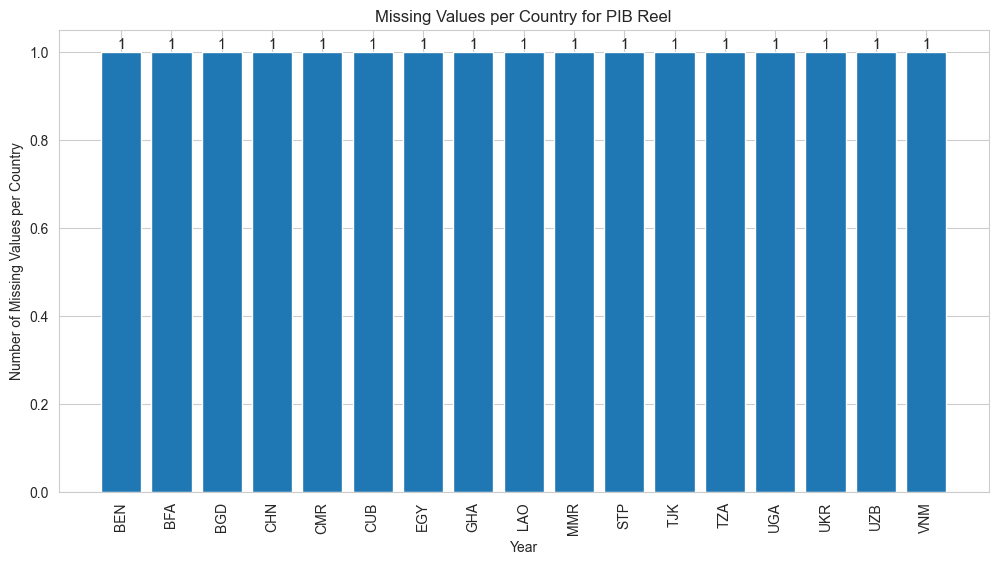

Index(['BEN', 'BFA', 'BGD', 'CHN', 'CMR', 'CUB', 'EGY', 'GHA', 'LAO', 'MMR',
       'STP', 'TJK', 'TZA', 'UGA', 'UKR', 'UZB', 'VNM'],
      dtype='object', name='country')

In [24]:
dv.plot_missing_values_per_country(responseTime_data,"avgResponseTime",treshold=0)

Certains des pays n'ont pas obtenu de temps de réponse avec notre algorithme. On pourrait modéliser en disant qu'ils ont un temps infiniment long ou juste prendre des valeurs arbitrairement grandes. Mais par souci de simplicité et de non penchant à faire des hypothèses fallacieuses, nous allons les sortir de la base de données et réaliser des études sur les pays qui ont un temps de réponse à des scénarios de crises.

In [25]:
responseTime_data.dropna(inplace=True)
responseTime_data.reset_index(drop=True,inplace=True)
responseTime_data

,country,avgResponseTime
0,AGO,1.945910
1,ALB,0.916291
2,AND,1.992430
3,ARE,0.980829
4,ARG,1.145132
...,...,...
157,VUT,1.504077
158,WSM,1.029619
159,ZAF,0.916291
160,ZMB,0.980829


# 4. Importations et exportations

L’étude des flux commerciaux internationaux offre un aperçu essentiel de la structure économique d’un pays et de sa capacité à absorber les chocs financiers. En effet, les importations et exportations reflètent la position d’un pays dans l’économie mondiale et sa dépendance vis-à-vis des marchés extérieurs.

Une balance commerciale excédentaire ou un ratio export/import élevé peuvent indiquer une économie plus autonome et robuste, tandis qu’un déficit chronique peut signaler une vulnérabilité accrue face aux crises externes. De plus, la diversité des échanges et l’ouverture commerciale contribuent à la flexibilité des pays et à leur capacité à réagir rapidement aux perturbations économiques.

Tout d’abord, nous avons commencé par récupérer les données relatives aux flux commerciaux pour l’ensemble des pays du monde, sur la période 1990-2024, en distinguant importations et exportations. Ces données sont harmonisées à l’aide des codes ISO-3 afin d’assurer une correspondance précise entre les pays et leurs séries temporelles.

Les DataFrames obtenus présentent ainsi une structure uniforme : chaque ligne correspond à un pays pour une année donnée, avec les valeurs d’importations et d’exportations. Les premières lignes montrent que certaines valeurs peuvent être manquantes, notamment pour les années les plus récentes ou pour certains pays où les données sont incomplètes.

In [26]:
wb = dc.WorldBankData()

liste_pays = codesISO_data["ISO-3"].tolist()
importations_data = wb.get_indicator("Importations", liste_pays, start=1990, end=2024)
exportations_data = wb.get_indicator("Exportations", liste_pays, start=1990, end=2024)

# Remplacer les noms des pays par leurs codes ISO dans les deux datasets
importations_data["country"] = importations_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
exportations_data["country"] = exportations_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)

importations_data

,country,date,Importations
0,AFG,2024,NaN
1,AFG,2023,50.731877
2,AFG,2022,54.505427
3,AFG,2021,37.069564
4,AFG,2020,36.289077
...,...,...,...
6750,ZWE,1994,36.519563
6751,ZWE,1993,32.448894
6752,ZWE,1992,36.484086
6753,ZWE,1991,27.168633


In [27]:
exportations_data

,country,date,Exportations
0,AFG,2024,NaN
1,AFG,2023,16.852788
2,AFG,2022,18.380042
3,AFG,2021,14.342153
4,AFG,2020,10.420817
...,...,...,...
6750,ZWE,1994,34.601298
6751,ZWE,1993,30.720621
6752,ZWE,1992,27.227979
6753,ZWE,1991,23.883877


Avant de procéder à toute analyse approfondie, il est essentiel d’évaluer la complétude des séries temporelles relatives aux importations et exportations. Le dataset couvre 187 pays pour la période allant de 1990 à 2024.

Une inspection des données révèle 1 232 valeurs manquantes sur un total de 6 755 observations, soit un ratio de 18,24 % de données absentes. Cette proportion est significative et justifie une attention particulière afin de ne pas biaiser les analyses ultérieures.

In [28]:
da.check_missing_values(importations_data,"Importations")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 18.24% de valeurs manquantes dans la base de données.

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 18.24% de valeurs manquantes dans la base de données.



Nous visualisons ensuite la répartition des valeurs manquantes par année. Cette approche permet de détecter des périodes où la couverture des données est plus faible, ce qui pourrait correspondre à des lacunes dans les statistiques nationales ou des retards de collecte. Les graphiques mettent en évidence que certaines années présentent davantage de données manquantes, ce qui pourrait influencer la précision des calculs d’indicateurs annuels. 

Nous observons ici qu'il y a systématiquement autant de valeurs manquantes par année pour les exportations que pour les importations ce qui est loin d'être surprenant et pouvons également relever une tendance à la baisse des valeurs manquantes au cours du temps, sûrement dû à une amélioration du système de collecte de données avec l'avancée technologique. L’année 2024, quant à elle, présente étonnamment un nombre plus élevé de valeurs manquantes par rapport aux années précédentes, avec 43 entrées manquantes. Cette hausse s’explique principalement par le décalage naturel de publication des données économiques récentes : les statistiques pour l’année la plus récente ne sont pas encore complètement consolidées ni validées par les institutions nationales et internationales. Certaines valeurs disponibles ne sont que des estimations partielles et certaines publications sont encore en attente, ce qui crée cette augmentation apparente des données manquantes.

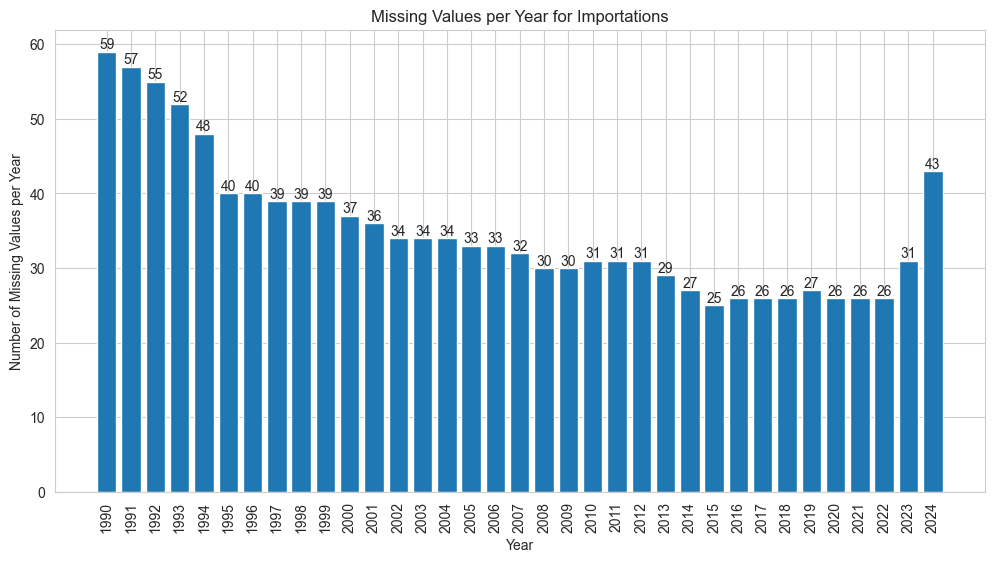

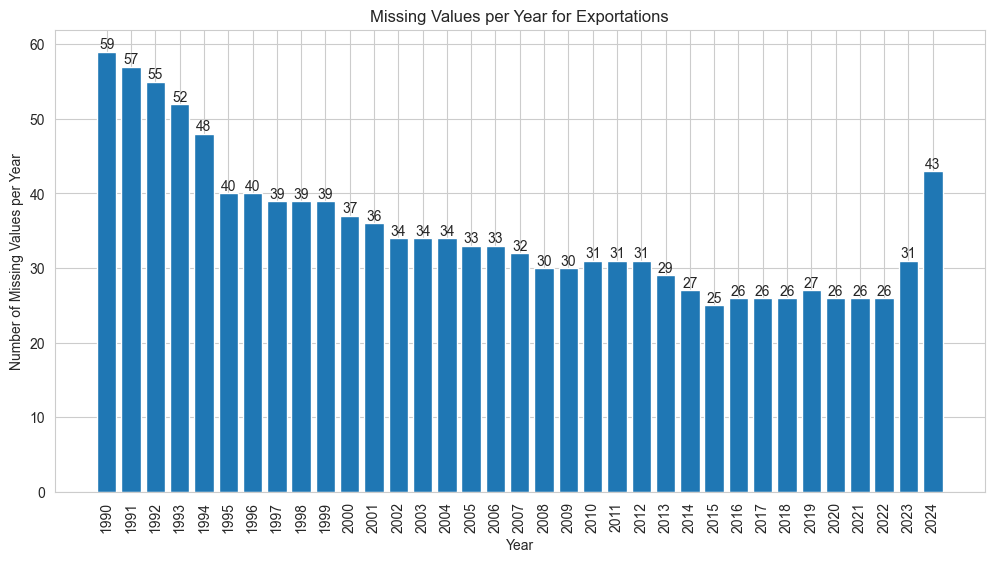

In [29]:
dv.plot_missing_values_per_year(importations_data,"Importations",text="Importations")
dv.plot_missing_values_per_year(exportations_data,"Exportations",text="Exportations")

Après avoir récupéré les séries temporelles pour 187 pays de 1990 à 2024, nous avons observé qu’un certain nombre de pays présentaient des données manquantes de manière significative. Plutôt que de tenter d’imputer des valeurs pour ces pays très lacunaires, ce qui aurait pu introduire des biais, nous avons choisi de les exclure du jeu de données.

Pour cela, nous avons défini un seuil de 10% de valeurs manquantes par pays. Les pays dépassant ce seuil ont été identifiés et leurs séries retirées des datasets. Cette étape permet de conserver uniquement des séries suffisamment complètes pour réaliser des analyses fiables.

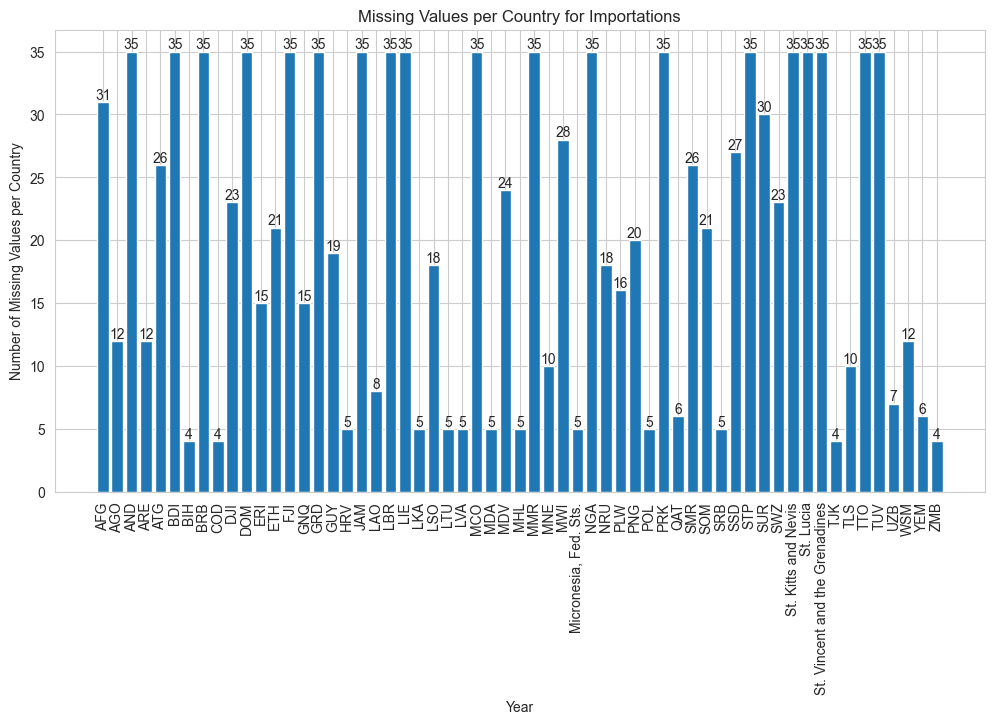

In [30]:
countries_toRemoveImportations = dv.plot_missing_values_per_country(importations_data,"Importations",treshold=0.1,text="Importations")

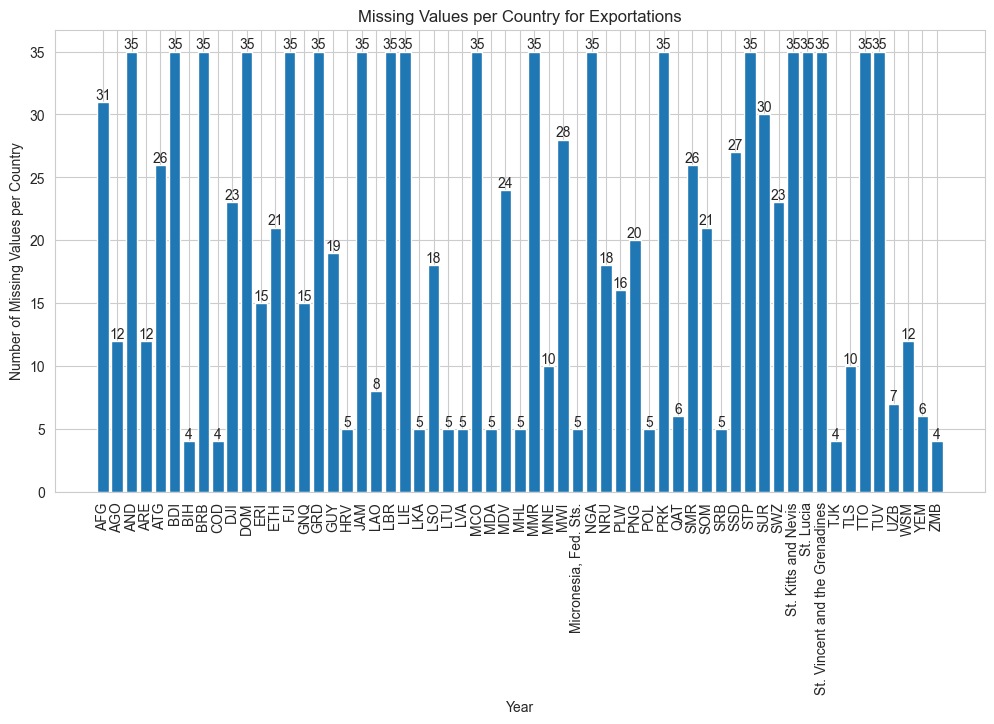

In [31]:
countries_toRemoveExportations = dv.plot_missing_values_per_country(exportations_data,"Exportations",treshold=0.1,text="Exportations")

Après cette opération, le nombre de pays inclus dans l’étude est passé de 187 à 129, et le taux de valeurs manquantes a été réduit à moins de 0,5%. Cette homogénéisation des données garantit que les indicateurs que nous calculerons par la suite seront robustes et comparables d’un pays à l’autre.

Cette démarche s’inscrit dans notre problématique générale : comprendre la vitesse de réponse des pays aux crises financières et identifier les facteurs structurels qui influencent cette capacité de résilience. En travaillant sur des séries fiables et continues, nous pouvons désormais examiner avec précision comment les flux commerciaux se comportent avant, pendant et après des épisodes de crise, et comparer les trajectoires des pays de manière pertinente.

In [32]:
indexes_toRemoveImports = []
indexes_toRemoveExports = []

for country in countries_toRemoveImportations:
    country_indexes = importations_data[importations_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

for country in countries_toRemoveExportations:
    country_indexes = exportations_data[exportations_data["country"]==country].index.tolist()
    indexes_toRemoveExports.extend(country_indexes)

In [33]:
da.check_missing_values(importations_data,"Importations")

importations_data = importations_data.drop(indexes_toRemove,axis='index')
importations_data.reset_index(drop=True,inplace=True)

da.check_missing_values(importations_data,"Importations")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 18.24% de valeurs manquantes dans la base de données.

Le dataframe contient des données temporelles relatives à 130 pays de 1990 à 2024.
Il y a 22 valeurs manquantes sur un total de 4550 dans la base de données.
Soit un ratio de 0.48% de valeurs manquantes dans la base de données.



In [34]:
da.check_missing_values(exportations_data,"Exportations")

exportations_data = exportations_data.drop(indexes_toRemove,axis='index')
exportations_data.reset_index(drop=True,inplace=True)

print("\n")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 18.24% de valeurs manquantes dans la base de données.



Le dataframe contient des données temporelles relatives à 130 pays de 1990 à 2024.
Il y a 22 valeurs manquantes sur un total de 4550 dans la base de données.
Soit un ratio de 0.48% de valeurs manquantes dans la base de données.



Après avoir retiré les pays présentant trop de données manquantes, il subsistait encore quelques lacunes, principalement concentrées sur les années les plus récentes ou les plus anciennes. Ces absences sont compréhensibles, car elles résultent comme nous l'avons dit plus tôt soit d’une indisponibilité historique des données pour les périodes anciennes, soit, pour les années récentes, du temps nécessaire aux sources statistiques pour publier et valider les chiffres les plus récents.

Pour garantir la continuité des séries temporelles et permettre un calcul fiable des indicateurs commerciaux, nous avons procédé à une imputation des valeurs manquantes. La méthode choisie combine un backward fill et un forward fill, ce qui permet de remplir les cases vides en utilisant les valeurs précédentes ou suivantes disponibles. Cette approche est simple, cohérente et évite d’introduire des biais trop importants, tout en respectant les tendances observées dans les données historiques.

Après cette opération, l’ensemble des séries pour les 129 pays retenus est désormais complet, sans aucune valeur manquante. Le ratio de données manquantes est ainsi ramené à 0%, ce qui garantit que tous les indicateurs dérivés calculés par la suite seront fiables et comparables sur l’ensemble de la période 1990‑2024.

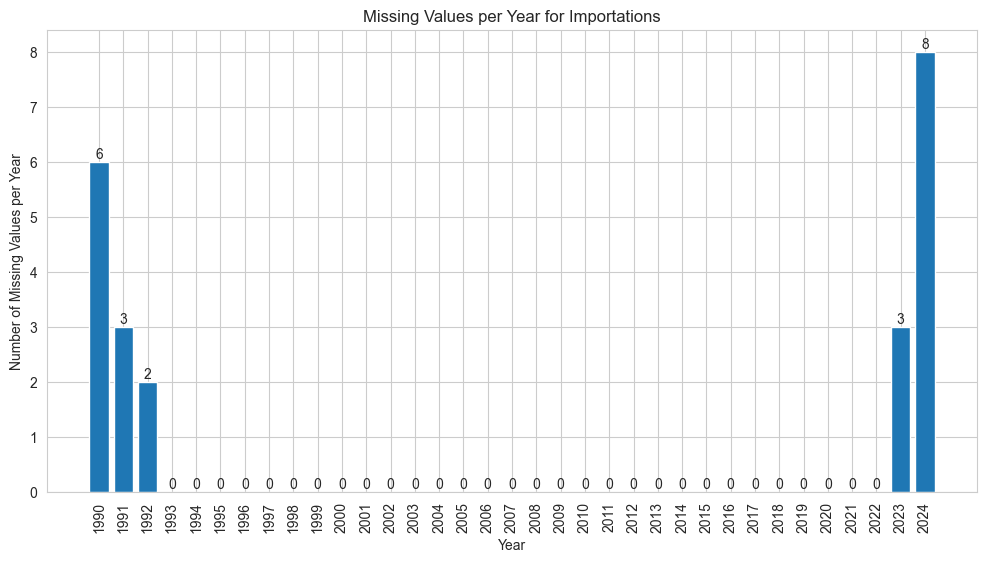

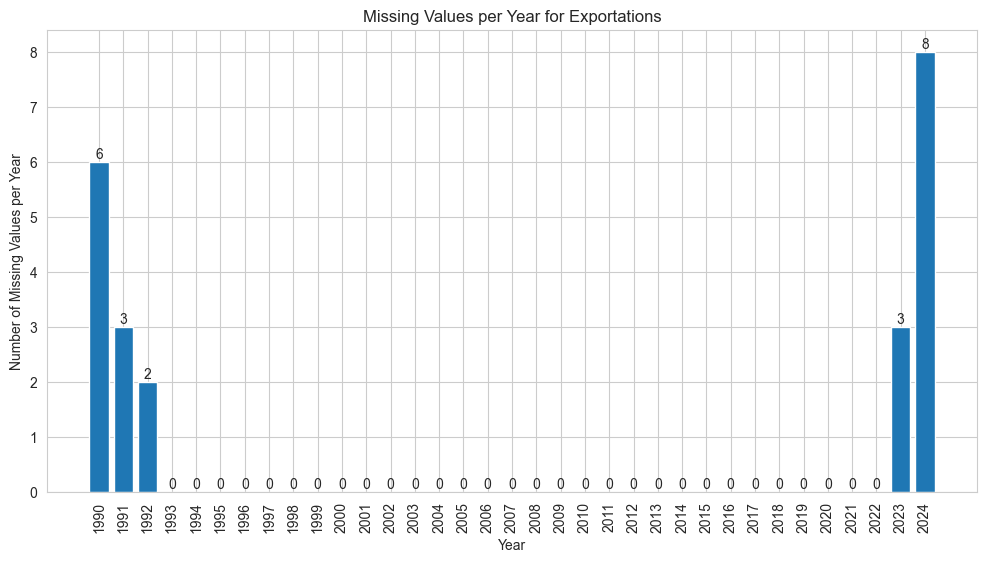

In [35]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(importations_data,"Importations",text="Importations")
dv.plot_missing_values_per_year(exportations_data,"Exportations",text="Exportations")

In [36]:
# Des valeurs manquantes sont en 2023, 2024. On peut les imputer avec la moyenne des années précédentes.
# On impute en backward fill puis forward fill pour les cas où il y a des années consécutives manquantes

importations_data = da.impute_missing_values(importations_data,"Importations",method="backward_fill")
importations_data = da.impute_missing_values(importations_data,"Importations",method="forward_fill")
da.check_missing_values(importations_data,"Importations")

Le dataframe contient des données temporelles relatives à 130 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 4550 dans la base de données.
Soit un ratio de 0.00% de valeurs manquantes dans la base de données.



In [37]:
# Des valeurs manquantes sont en 2023, 2024. On peut les imputer avec la moyenne des années précédentes.
# On impute en backward fill puis forward fill pour les cas où il y a des années consécutives manquantes

exportations_data = da.impute_missing_values(exportations_data,"Exportations",method="backward_fill")
exportations_data = da.impute_missing_values(exportations_data,"Exportations",method="forward_fill")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 130 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 4550 dans la base de données.
Soit un ratio de 0.00% de valeurs manquantes dans la base de données.



Une fois cette étape de nettoyage réalisée, nous avons fusionné les deux jeux de données afin d’obtenir un cadre complet pour l’analyse des flux commerciaux. Chaque ligne du tableau représente ainsi un pays pour une année donnée, avec ses volumes d’importations et d’exportations correspondants.

**NOTE : Toutes les valeurs présentées dans cette section sont exprimées en pourcentage du PIB, ce qui permet de comparer les importations, exportations et soldes commerciaux indépendamment de la taille absolue des économies.**

In [38]:
# Fusion des deux datasets pour analyse conjointe
trade_data = pd.merge(importations_data,exportations_data,on=['country','date'])
trade_data

,country,date,Importations,Exportations
0,ALB,2024,43.169768,36.284869
1,ALB,2023,43.933672,38.418821
2,ALB,2022,47.500968,37.197076
3,ALB,2021,44.457348,31.133056
4,ALB,2020,36.979941,22.540759
...,...,...,...,...
4545,ZWE,1994,36.519563,34.601298
4546,ZWE,1993,32.448894,30.720621
4547,ZWE,1992,36.484086,27.227979
4548,ZWE,1991,27.168633,23.883877


In [39]:
trade_analyzer = da.TradeDataAnalyzer(trade_data=trade_data)
trade_analyzer.trade_data

,country,date,Importations,Exportations
0,ALB,2024,43.169768,36.284869
1,ALB,2023,43.933672,38.418821
2,ALB,2022,47.500968,37.197076
3,ALB,2021,44.457348,31.133056
4,ALB,2020,36.979941,22.540759
...,...,...,...,...
4545,ZWE,1994,36.519563,34.601298
4546,ZWE,1993,32.448894,30.720621
4547,ZWE,1992,36.484086,27.227979
4548,ZWE,1991,27.168633,23.883877


Afin de mieux comprendre la position commerciale de chaque pays, nous avons calculé la balance commerciale, définie comme la différence entre les exportations et les importations. Une valeur positive indique que le pays est un exportateur net, tandis qu’une valeur négative signale un importateur net. Cette approche permet de visualiser rapidement les pays qui contribuent le plus aux flux commerciaux mondiaux chaque année et ceux qui en dépendent davantage pour leurs importations.

In [40]:
trade_analyzer.get_balance()
trade_analyzer.trade_data


,country,date,Importations,Exportations,commBalance
0,ALB,2024,43.169768,36.284869,-6.884899
1,ALB,2023,43.933672,38.418821,-5.514851
2,ALB,2022,47.500968,37.197076,-10.303892
3,ALB,2021,44.457348,31.133056,-13.324292
4,ALB,2020,36.979941,22.540759,-14.439182
...,...,...,...,...,...
4545,ZWE,1994,36.519563,34.601298,-1.918265
4546,ZWE,1993,32.448894,30.720621,-1.728273
4547,ZWE,1992,36.484086,27.227979,-9.256107
4548,ZWE,1991,27.168633,23.883877,-3.284756




Nous commençons par examiner les caractéristiques générales des flux commerciaux à l’échelle mondiale, en nous appuyant sur les données consolidées d’importations, d’exportations et de balance commerciale pour l’ensemble des pays retenus.

Les importations présentent une moyenne de 41,92%, avec des écarts significatifs entre pays (écart-type de 24,01%). Certaines économies montrent des volumes très modestes, proches de zéro, tandis que d’autres atteignent des valeurs supérieures à 200, illustrant la diversité des capacités d’approvisionnement et la taille des marchés nationaux.

Les exportations, quant à elles, sont légèrement inférieures en moyenne (38,06%), mais leur dispersion est encore plus marquée (écart-type de 27,08%), et certains pays dépassent largement les 200% de leur PIB, traduisant une forte hétérogénéité dans la capacité à produire et à vendre sur les marchés internationaux.

La balance commerciale moyenne est négative (-3,86%), indiquant que, globalement, les importations excèdent légèrement les exportations dans l’échantillon. Toutefois, cette valeur moyenne masque des différences importantes entre pays : la majorité des pays se situent autour d’un déficit ou d’un léger excédent, mais quelques-uns affichent des déséquilibres très prononcés, allant jusqu’à -108,81% pour le déficit et 48,45% pour l’excédent.

L’analyse des quartiles renforce cette impression de disparité : la moitié des pays importent entre 26,16% et 53,14% de leur PIB, exportent entre 20,66% et 47,59%, et présentent des balances commerciales comprises entre -10,09% et 3,07%. Ces observations soulignent la diversité structurelle des économies, un facteur crucial pour comprendre leur vulnérabilité et leur capacité de réponse face aux crises financières et aux chocs externes.

In [41]:
# Statistiques globales des importations, exportations et balance commerciale
trade_data[['Importations', 'Exportations', 'commBalance']].describe()


,Importations,Exportations,commBalance
count,4550.000000,4550.000000,4550.000000
mean,42.147499,38.285825,-3.861675
std,23.958787,27.060292,14.914815
min,0.015622,0.005377,-108.808876
25%,26.301207,20.974088,-10.138594
50%,35.182487,31.621662,-2.057244
75%,53.311722,47.712910,3.103229
max,208.332944,228.993771,48.452239


Pour comprendre davantage la structure des échanges internationaux, nous avons représenté la distribution des importations, exportations et balances commerciales pour l’ensemble des pays de la base de données.

L’histogramme des importations montre que la majorité des pays ont des flux modérés, mais quelques pays présentent des importations très élevées, ce qui reflète l’existence d’économies fortement intégrées au commerce mondial.

L’histogramme des exportations révèle une distribution similaire, avec une concentration de pays autour de valeurs moyennes, et quelques outliers à très forte capacité exportatrice.

Enfin, l’histogramme de la balance commerciale met en évidence que la plupart des pays se situent autour d’un léger déficit ou excédent, tandis que certains pays affichent des déséquilibres commerciaux très prononcés, positifs ou négatifs.

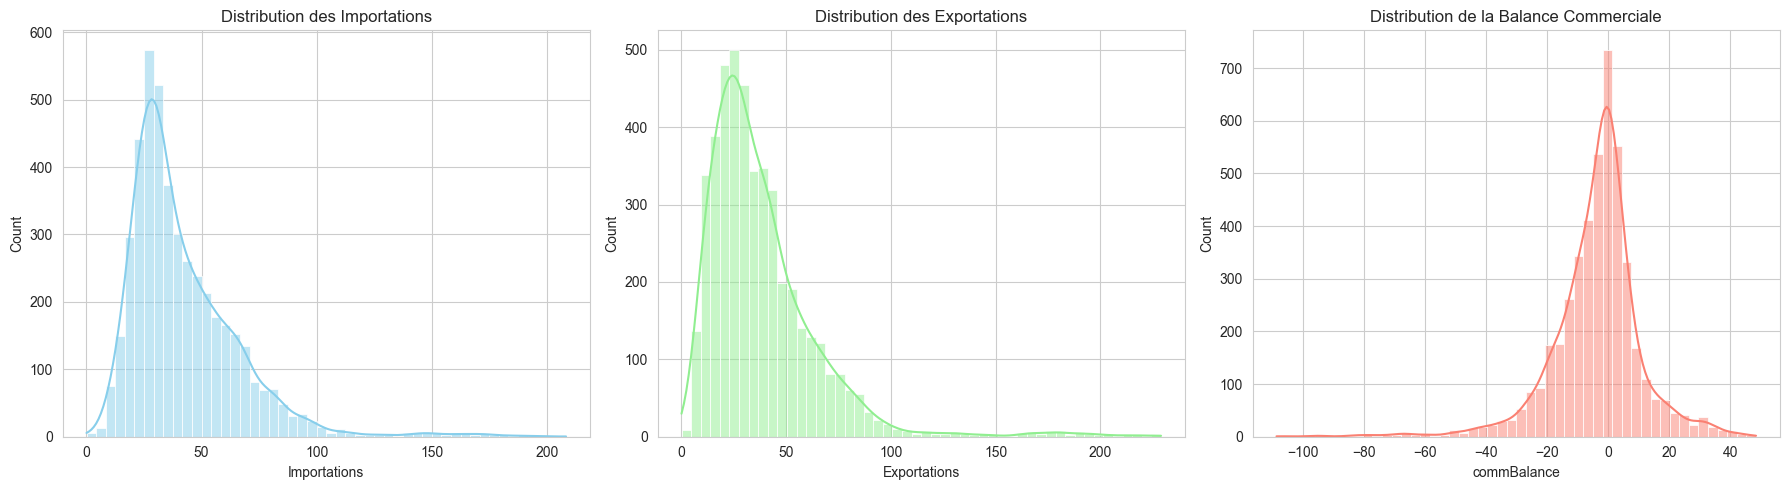

In [42]:
# Histogrammes des importations, exportations et balances commerciales
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(trade_data['Importations'], bins=50, ax=axes[0], kde=True, color='skyblue')
axes[0].set_title("Distribution des Importations")

sns.histplot(trade_data['Exportations'], bins=50, ax=axes[1], kde=True, color='lightgreen')
axes[1].set_title("Distribution des Exportations")

sns.histplot(trade_data['commBalance'], bins=50, ax=axes[2], kde=True, color='salmon')
axes[2].set_title("Distribution de la Balance Commerciale")

plt.tight_layout()
plt.show()


L’examen de la balance commerciale moyenne permet de distinguer deux groupes de pays aux trajectoires économiques opposées.

**Top 10 exportateurs nets :**
On remarque que le Luxembourg, le Gabon et Singapour occupent les premières places avec des balances commerciales moyennes très positives, supérieures à 23 % du PIB. Ces pays affichent une capacité d’exportation nettement supérieure à leurs importations, ce qui reflète soit une spécialisation forte dans certains secteurs exportateurs, soit une économie relativement ouverte et compétitive à l’international. D’autres pays de ce top 10, tels que Brunei, l’Irlande ou l’Arabie Saoudite, présentent également des excédents commerciaux significatifs, souvent liés à des ressources naturelles ou à des positions stratégiques dans le commerce mondial.

**Top 10 importateurs nets :**
À l’inverse, certains pays présentent des déficits commerciaux soutenus. L’Armenie, la Guinée-Bissau et l’Albanie sont les moins favorisés, avec des balances largement négatives, allant jusqu’à -74 % du PIB pour Kiribati. Ces déficits reflètent des économies plus dépendantes des importations pour leur consommation ou leur production, ou encore des structures économiques moins orientées vers l’exportation. Le constat est particulièrement marqué pour des petites économies insulaires ou des pays à faible diversification industrielle.

In [43]:
# Calcul de la balance moyenne
balance_avg = trade_data.groupby('country')['commBalance'].mean().sort_values(ascending=False)

# Top 10 exportateurs nets
top10 = balance_avg.head(10).reset_index()
top10 = top10.merge(codesISO_data[['Pays','ISO-3']], left_on='country', right_on='ISO-3', how='left')
top10 = top10[['Pays','commBalance']].rename(columns={'Pays':'country_name'})
top10.index = range(1, len(top10)+1)  
print("Top 10 pays exportateurs nets :")
display(top10)

# Top 10 importateurs nets (flop)
flop10 = balance_avg.tail(10).reset_index()
flop10 = flop10.merge(codesISO_data[['Pays','ISO-3']], left_on='country', right_on='ISO-3', how='left')
flop10 = flop10[['Pays','commBalance']].rename(columns={'Pays':'country_name'})
flop10.index = range(1, len(flop10)+1)  
print("\nTop 10 pays importateurs nets :")
display(flop10)



Top 10 pays exportateurs nets :


,country_name,commBalance
1,Luxembourg,25.985188
2,Gabon,25.591329
3,Singapore,23.709145
4,Brunei Darussalam[i],18.756416
5,Ireland,17.019870
6,Kuwait,15.234770
7,Oman,14.586263
8,Libya,13.565321
9,Bahrain,13.220006
10,Saudi Arabia,12.904544



Top 10 pays importateurs nets :


,country_name,commBalance
1,Armenia,-19.229128
2,Guinea-Bissau,-20.014752
3,Albania,-21.712002
4,Jordan,-23.864737
5,Kyrgyzstan,-24.926637
6,Mozambique,-27.658703
7,Cabo Verde[j],-27.865427
8,Lebanon,-33.480745
9,Tonga,-39.439085
10,Kiribati,-74.080769


Pour des soucis de lisibilité, nous avons sélectionné les 5 pays avec les plus forts excédents commerciaux (Top 5 exportateurs nets) et les 5 pays avec les plus forts déficits commerciaux (Flop 5 importateurs nets). L’objectif était de visualiser l’évolution de leur balance commerciale au fil du temps et d’identifier les tendances générales pour les pays les plus performants et les plus dépendants du commerce extérieur.

On observe clairement deux dynamiques distinctes. Du côté des Top 5 exportateurs nets, les courbes restent généralement au-dessus de zéro, ce qui signifie que ces pays ont un excédent commercial régulier. Certains pays peuvent avoir des variations légères selon les années, mais la tendance générale reste positive, montrant une certaine stabilité économique et un rôle important dans le commerce international.

À l’inverse, les Flop 5 importateurs nets présentent des courbes systématiquement négatives. Cela reflète des déficits commerciaux persistants : ces pays dépendent des importations pour répondre à leurs besoins, ce qui peut être le signe d’une production locale plus faible ou d’une forte consommation de biens étrangers. On remarque parfois des pics ou des creux importants, ce qui pourrait correspondre à des crises économiques, à des fluctuations des prix mondiaux ou à des changements dans les politiques commerciales.

En comparant les deux groupes, la disparité est frappante. Les Top 5 dominent le commerce mondial sur la période étudiée, alors que les Flop 5 subissent une pression économique plus forte. Cette visualisation permet aussi de voir que la balance commerciale n’est pas statique : certains pays peuvent améliorer ou détériorer leur position au fil des années, et ces tendances peuvent être analysées pour comprendre les stratégies économiques, les chocs externes ou les dépendances spécifiques

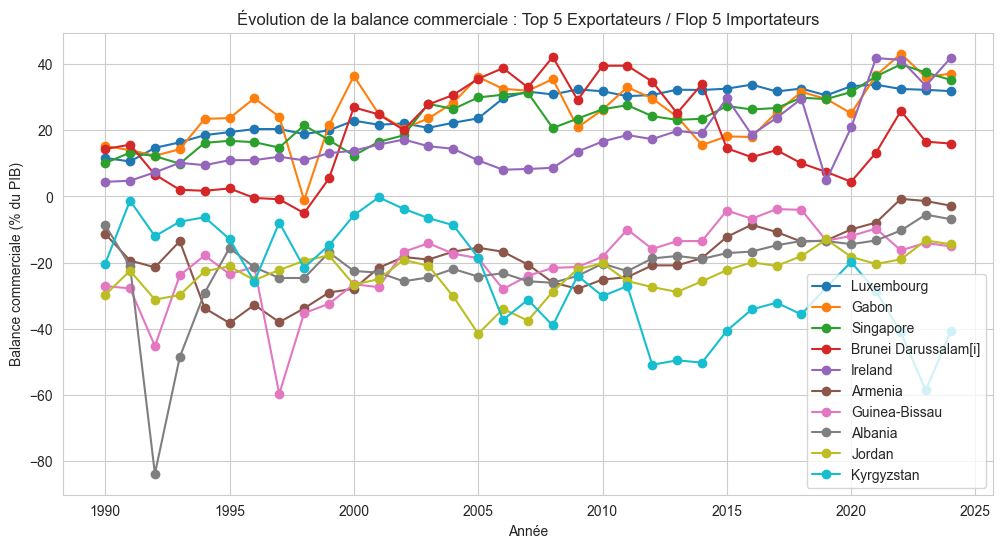

In [44]:
# Top 5 exportateurs nets
top5 = top10.head(5)['country_name']
# Flop 5 importateurs nets
flop5 = flop10.head(5)['country_name']

top_flop_countries = pd.concat([top5, flop5])

plt.figure(figsize=(12,6))
for country in top_flop_countries:
    subset = trade_data.merge(codesISO_data[['Pays','ISO-3']], left_on='country', right_on='ISO-3', how='left')
    subset = subset[subset['Pays'] == country]
    plt.plot(subset['date'], subset['commBalance'], marker='o', label=country)

plt.title("Évolution de la balance commerciale : Top 5 Exportateurs / Flop 5 Importateurs")
plt.xlabel("Année")
plt.ylabel("Balance commerciale (% du PIB)")
plt.legend()
plt.grid(True)
plt.show()




**Cartographie**

Nous proposons ci-dessous une représentation visuelle de la balance commmerciale moyenne des 30 dernières années par pays.

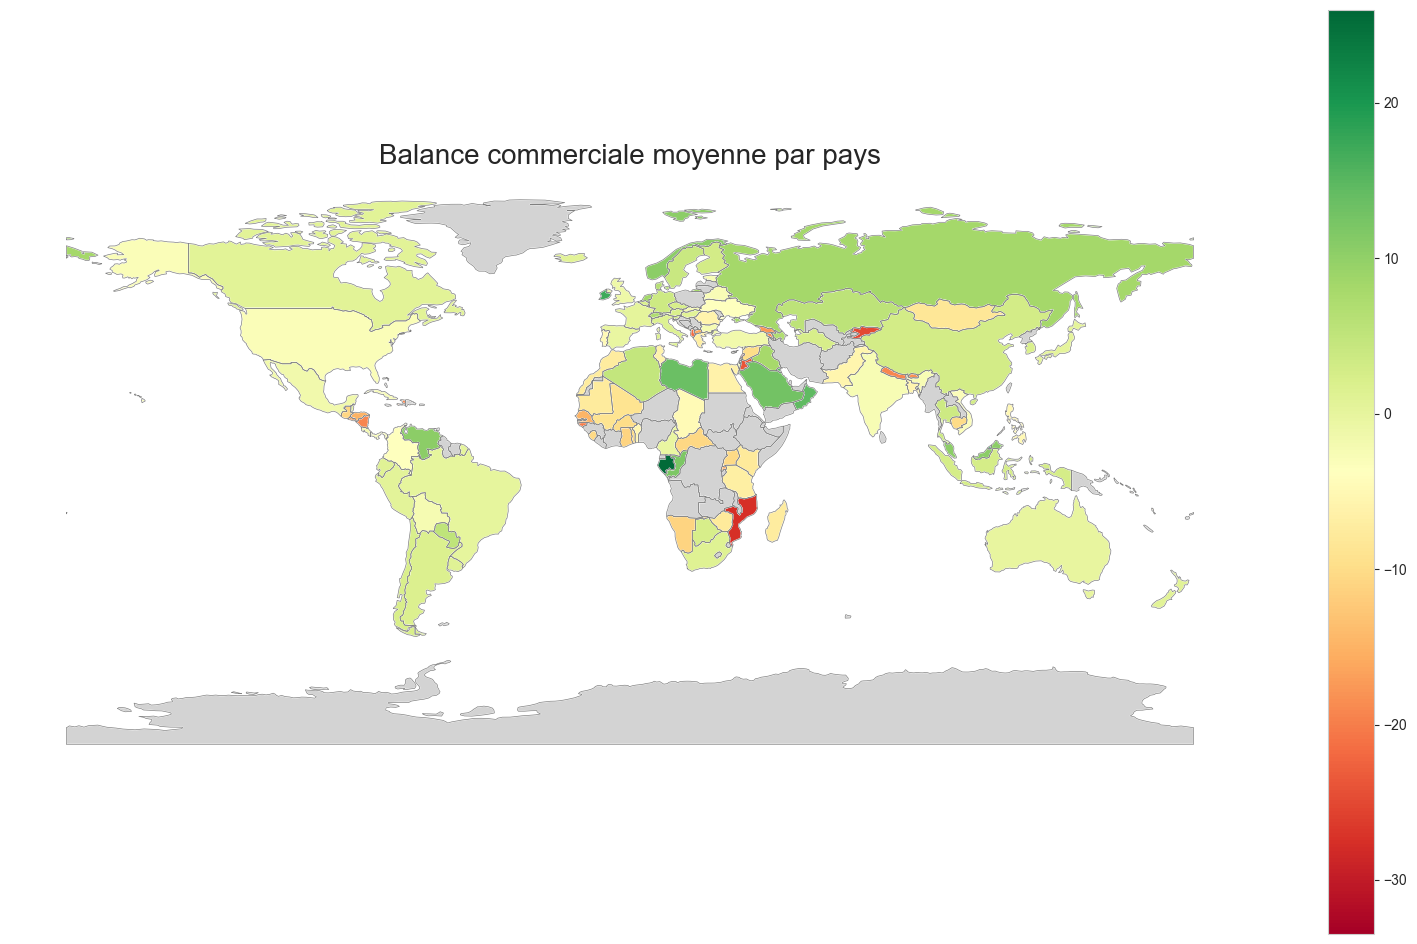

In [45]:

world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
# Fusionner avec les codes ISO et le shapefile
avg_balance = trade_data.groupby('country')['commBalance'].mean().reset_index()
avg_balance = avg_balance.merge(codesISO_data[['ISO-3','Pays']], left_on='country', right_on='ISO-3', how='left')
world_map = world.merge(avg_balance, left_on='ADM0_A3', right_on='ISO-3', how='left')

# Tracer la carte
fig, ax = plt.subplots(1, 1, figsize=(20,12))
world.boundary.plot(ax=ax, linewidth=0.5, color='gray')
world_map.plot(
    column='commBalance',
    ax=ax,
    legend=True,
    cmap='RdYlGn',
    missing_kwds={"color": "lightgrey"},
)
ax.set_title("Balance commerciale moyenne par pays", fontsize=20)
ax.axis('off')
plt.show()

# Classification en pays exportateurs nets

In [46]:
netExportators = trade_analyzer.classify_exporters(threshold=0)
netExportators

,country,netExportateur
0,ALB,0
1,ARG,1
2,ARM,0
3,AUS,0
4,AUT,1
...,...,...
125,VEN,1
126,VNM,0
127,VUT,0
128,ZAF,1


# Visualisation sur une carte

Nous représentons sur une carte la variable binaire identifiant les pays exportateurs nets. La carte met en évidence une forte concentration de ces pays dans les économies avancées et riches en ressources (Europe occidentale, pays du Golfe, certaines économies asiatiques), tandis que de nombreux pays d’Afrique et d’Amérique latine apparaissent majoritairement importateurs nets. Cette répartition confirme l’existence d’un clivage structurel dans le commerce international et suggère que le statut d’exportateur net est étroitement lié au niveau de développement économique et à la spécialisation productive.

In [47]:
dv.visualize_trade_clusters(netExportators)

# Analyse des pays enclavés

In [48]:
try:
    landlocked_data = dc.get_rawlandlockedCountries(landlocked_url)
    landlocked_data = dcl.clean_landlockedData(landlocked_data)
except Exception as e:
    print(f"An error occurred while fetching or cleaning ISO codes data: {e}")
    landlocked_data = pd.read_csv("data/landlocked_data.csv")
    landlocked_data.drop(columns=['Unnamed: 0'], inplace=True)

landlocked_data

,country,Coastline
1,Canada,265523.0
2,Norway,53199.0
3,Indonesia,95181.0
4,European Union,NaN
5,Greenland,NaN
...,...,...
254,French Guiana,763.0
255,Guadeloupe,581.0
256,Martinique,369.0
257,Caribbean Netherlands,361.0


In [49]:
landlocked_data["country"] = landlocked_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
landlocked_data

,country,Coastline
1,CAN,265523.0
2,NOR,53199.0
3,IDN,95181.0
4,European Union,NaN
5,Greenland,NaN
...,...,...
254,French Guiana,763.0
255,Guadeloupe,581.0
256,Martinique,369.0
257,Caribbean Netherlands,361.0


In [50]:
# Récupérer les pays avec des codes ISO à 3 lettres. Les pays qui n'ont pas de code ISO à 3 lettres ne sont pas reconnus par la World Bank donc on les enlève
validLandlockedData = landlocked_data[landlocked_data['country'].str.len() == 3].copy()
validLandlockedData

,country,Coastline
1,CAN,265523.0
2,NOR,53199.0
3,IDN,95181.0
7,PHL,33900.0
8,JPN,29020.0
...,...,...
248,TJK,0.0
249,UGA,0.0
250,UZB,1707.0
252,ZMB,0.0


In [51]:
# On va créer une colonne binaire pour indiquer si un pays est enclavé ou non
validLandlockedData['isLandlocked'] = (validLandlockedData['Coastline'] == 0).astype(int)
validLandlockedData.drop(columns=['Coastline'],inplace=True)
validLandlockedData

,country,isLandlocked
1,CAN,0
2,NOR,0
3,IDN,0
7,PHL,0
8,JPN,0
...,...,...
248,TJK,1
249,UGA,1
250,UZB,0
252,ZMB,1


In [52]:
dv.visualize_landlocked_countries(validLandlockedData)

## HDI Data

Après avoir étudié la structure commerciale des pays à travers leurs importations et exportations, il est pertinent d’introduire une dimension plus structurelle du développement. Le commerce extérieur renseigne sur l’insertion internationale des économies, mais il ne suffit pas à capturer leur niveau de développement humain, qui conditionne fortement leur capacité à absorber et surmonter les chocs. C’est dans cette optique que l’on introduit l’Indice de Développement Humain (HDI), indicateur synthétique central pour compléter l’analyse.

Le jeu de données HDI importé contient les valeurs annuelles de l’Indice de Développement Humain pour l’ensemble des pays, ainsi qu’un agrégat mondial, sur la période 1990–2023. À l’origine, la base est relativement riche (10 colonnes), mais seule une partie de l’information est utile pour l’analyse : le pays, l’année et la valeur de l’HDI.

In [53]:
HDI_data = pd.read_excel("data/hdi-data.xlsx")
HDI_data


,countryIsoCode,country,indexCode,index,dimension,indicatorCode,indicator,year,value,note
0,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1990,0.285,NaN
1,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1991,0.291,NaN
2,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1992,0.301,NaN
3,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1993,0.311,NaN
4,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1994,0.305,NaN
...,...,...,...,...,...,...,...,...,...,...
6309,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2019,0.745,NaN
6310,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2020,0.742,NaN
6311,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.742,NaN
6312,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2022,0.752,NaN


In [54]:
print("Il y a", HDI_data["country"].nunique(), "pays uniques dans le dataset HDI avant nettoyage.")

Il y a 204 pays uniques dans le dataset HDI avant nettoyage.


La classe HDIDataAnalyzer permet de nettoyer et de restructurer ces données. Le traitement consiste essentiellement à :

-filtrer l’indicateur pertinent (HDI),

-harmoniser les identifiants pays (codes ISO),

-renommer les variables pour plus de clarté,

-éliminer les colonnes redondantes ou non exploitables.

On obtient ainsi une base finale épurée de 5 940 observations, avec une structure simple et cohérente : une observation par pays et par année, et une variable continue HDI comprise entre 0 et 1. Cette base est directement exploitable pour des analyses descriptives (comparaisons entre pays, dynamiques temporelles) et servira ensuite de fondement pour relier le niveau de développement humain aux autres dimensions étudiées dans le projet.

In [55]:
hdiAnalyzer = da.HDIDataAnalyzer(HDI_data=HDI_data)
HDI_cleaned = hdiAnalyzer.clean_data()
HDI_cleaned




,country,date,HDI
0,AFG,1990,0.285
1,AFG,1991,0.291
2,AFG,1992,0.301
3,AFG,1993,0.311
4,AFG,1994,0.305
...,...,...,...
5935,ZWE,2019,0.584
5936,ZWE,2020,0.582
5937,ZWE,2021,0.581
5938,ZWE,2022,0.594


In [56]:
HDI_cleaned["country"].nunique()
print("Il y a", HDI_cleaned["country"].nunique(), "pays uniques dans le dataset HDI après nettoyage.")

Il y a 193 pays uniques dans le dataset HDI après nettoyage.


On vérifie qu'on n'a bel et bien pas de valeurs manquantes.

In [57]:
da.check_missing_values(HDI_cleaned,"HDI")

Le dataframe contient des données temporelles relatives à 193 pays de 1990 à 2023.
Il y a 0 valeurs manquantes sur un total de 5940 dans la base de données.
Soit un ratio de 0.00% de valeurs manquantes dans la base de données.



Le dataset contient 193 pays distincts après nettoyage.
En moyenne, chaque pays dispose d’environ 31 années de données HDI.
La médiane est de 34 années, ce qui correspond quasiment à la période complète 1990–2023.

In [58]:
HDI_cleaned.groupby("country")["date"].count().describe()

count    193.000000
mean      30.777202
std        5.936039
min        2.000000
25%       29.000000
50%       34.000000
75%       34.000000
max       34.000000
Name: date, dtype: float64

Nous agrégeons ensuite l’Indice de Développement Humain au niveau des pays en calculant, pour chacun d’eux, une valeur moyenne d’HDI sur l’ensemble de la période observée.
L’objectif est de disposer d’un indicateur synthétique et comparable du niveau moyen de développement humain, indépendamment des fluctuations annuelles.

En analysant l’indice de développement humain moyen par pays sur la période étudiée, on observe une nette hiérarchisation. Le top 10 regroupe des pays majoritairement européens et nord-américains, avec des HDI moyens supérieurs à 0,90, reflétant un niveau de vie élevé, une espérance de vie longue et un accès important à l’éducation. À l’inverse, le flop 10 inclut principalement des pays d’Afrique subsaharienne, avec des HDI moyens inférieurs à 0,42, témoignant de défis persistants en matière de santé, d’éducation et de conditions économiques.

In [59]:
aggregated_HDI = hdiAnalyzer.aggregated_HDI()
# Tri par HDI moyen
HDI_avg = aggregated_HDI.sort_values(by="HDI_mean", ascending=False)

# Top 10 pays par HDI
top10_HDI = HDI_avg.head(10).reset_index(drop=True)
top10_HDI.index = range(1, len(top10_HDI)+1)
print("Top 10 pays par HDI :")
display(top10_HDI)

# Flop 10 pays par HDI
flop10_HDI = HDI_avg.tail(10).reset_index(drop=True)
flop10_HDI.index = range(1, len(flop10_HDI)+1)
print("\nFlop 10 pays par HDI :")
display(flop10_HDI)

Top 10 pays par HDI :


,country,HDI_mean
1,NOR,0.930912
2,ISL,0.922324
3,CHE,0.919324
4,DEU,0.916088
5,LIE,0.915958
6,AUS,0.914588
7,NLD,0.913706
8,DNK,0.911765
9,SWE,0.911147
10,USA,0.909147



Flop 10 pays par HDI :


,country,HDI_mean
1,GIN,0.401529
2,SOM,0.394500
3,SLE,0.379853
4,MOZ,0.374000
5,TCD,0.372292
6,SSD,0.372286
7,BDI,0.368294
8,MLI,0.357912
9,CAF,0.346625
10,NER,0.314412


**Cartographie**

Nous proposons une représentation plus visuelle à l'aide d'une carte dynamique. Un slider permet de sélectionner manuellement l'année souhaitée. Il est aussi possible de faire défiler automatiquement le temps de deux manières : lentement, avec le bouton ▶, et rapidement, avec le bouton « Quick ».

In [60]:
HDI_for_map = HDI_cleaned.rename(columns={'country':'country_code', 'date':'year'})
dv.plot_world_map(HDI_for_map, y_col='HDI', data_name='HDI', width=1000, height=600)

In [61]:
dv.visualize_HDI_clusters(aggregated_HDI)

# Fusion des bases

In [62]:
merged_data = (
    aggregated_HDI
    .merge(responseTime_data, on=["country"], how="outer")
    .merge(validLandlockedData, on=["country"], how="outer")
    .merge(netExportators, on=["country"], how="outer")
    .merge(weightCountry, on=["country"], how="outer")
)

merged_data.sort_values(by="country",ascending=True)

,country,HDI_mean,avgResponseTime,isLandlocked,netExportateur,avgWeightCountry
0,AFG,0.415853,NaN,1.0,NaN,NaN
1,AGO,0.527600,1.945910,0.0,NaN,0.102863
2,ALB,0.727824,0.916291,0.0,0.0,0.014401
3,AND,0.862833,1.992430,0.0,NaN,0.004426
4,ARE,0.820941,0.980829,0.0,NaN,0.444654
...,...,...,...,...,...,...
201,WSM,0.694655,1.029619,0.0,NaN,0.001154
202,YEM,0.450853,NaN,NaN,NaN,NaN
203,ZAF,0.667618,0.916291,0.0,1.0,0.467429
204,ZMB,0.495559,0.980829,1.0,NaN,0.022953


In [63]:
merged_data.dropna(inplace=True)
merged_data

,country,HDI_mean,avgResponseTime,isLandlocked,netExportateur,avgWeightCountry
2,ALB,0.727824,0.916291,0.0,0.0,0.014401
5,ARG,0.813059,1.145132,0.0,1.0,0.795024
6,ARM,0.716588,1.386294,1.0,0.0,0.012419
8,AUS,0.914588,0.693147,0.0,0.0,1.814523
9,AUT,0.893706,0.980829,1.0,1.0,0.583434
...,...,...,...,...,...,...
195,USA,0.909147,0.693147,0.0,0.0,26.250237
198,VEN,0.721382,1.098612,0.0,1.0,0.167288
200,VUT,0.595632,1.504077,0.0,0.0,0.001051
203,ZAF,0.667618,0.916291,0.0,1.0,0.467429


# Implémentation de la régression

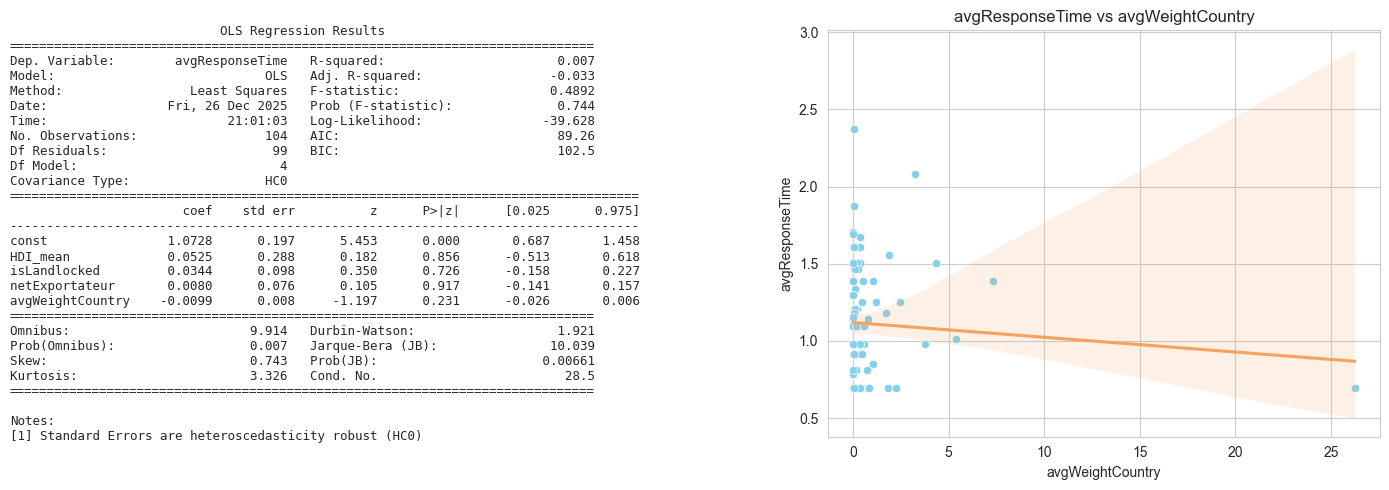

In [64]:
rg.perform_regression(merged_data, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC0')

# Régression sans les USA

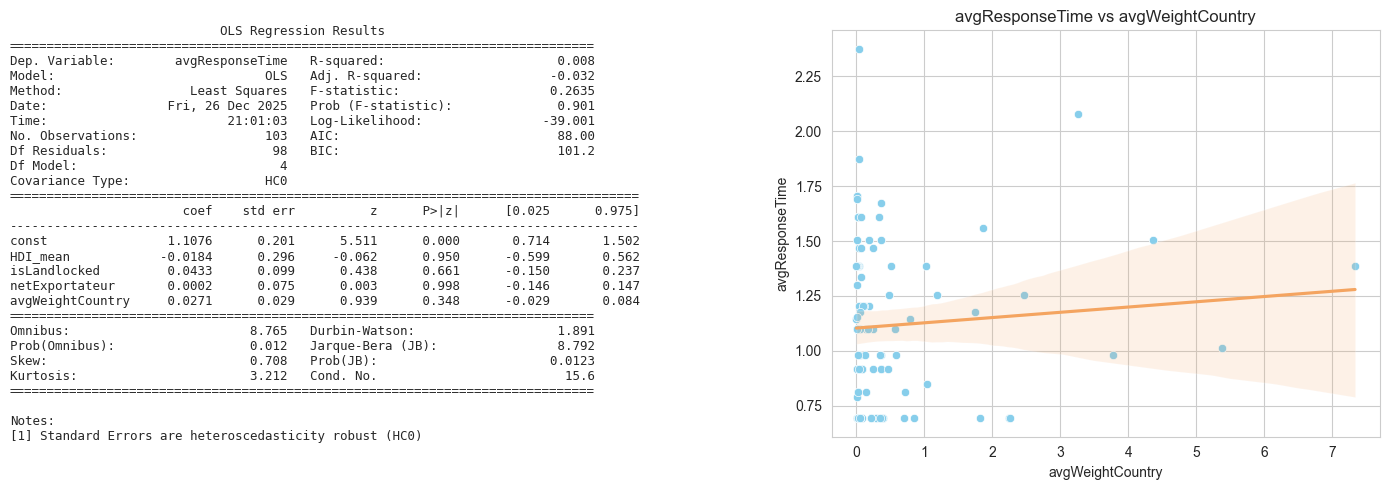

In [65]:
dataWithout_USA = merged_data[merged_data["country"]!="USA"]
rg.perform_regression(dataWithout_USA, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC0')

# Régressions séparées

In [66]:
highPowerCountries = clusters_EconomicPower[(clusters_EconomicPower["Power"] == 2) | (clusters_EconomicPower["Power"] == 3) | (clusters_EconomicPower["Power"] == 1)]["country"].tolist()
lowPowerCountries = clusters_EconomicPower[(clusters_EconomicPower["Power"] == 0)].sort_values(by="avgWeightCountry",ascending=False)["country"].tolist()

In [67]:
dataHighPower = merged_data[merged_data["country"].isin(highPowerCountries[:-1]+lowPowerCountries[:11])]
dataLowPower = merged_data[merged_data["country"].isin(lowPowerCountries[11:])]

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.

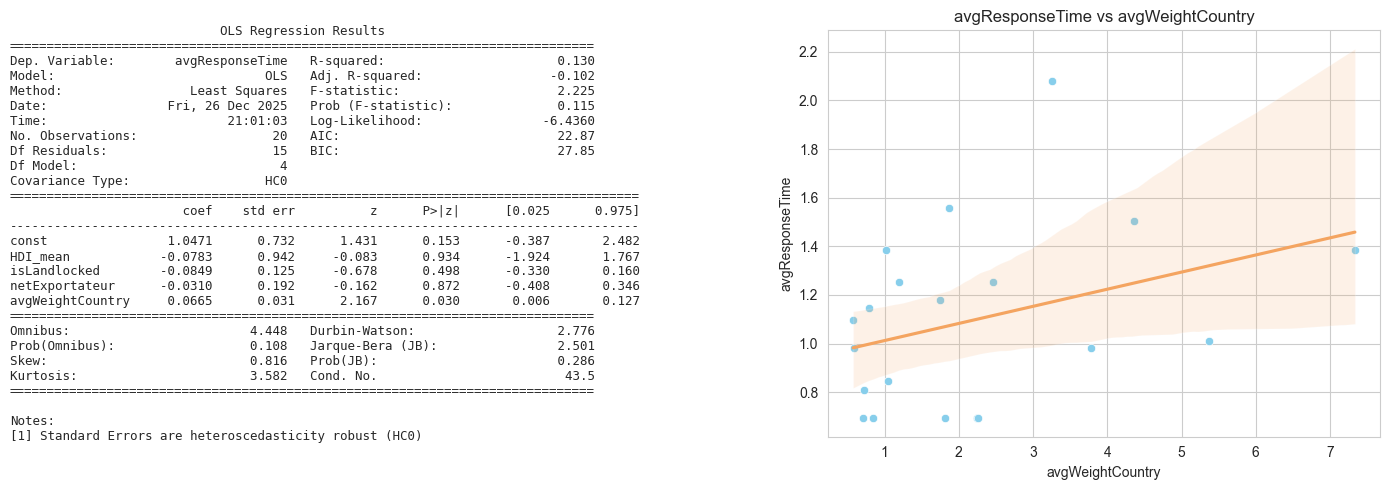

In [68]:
rg.perform_regression(dataHighPower, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC0')

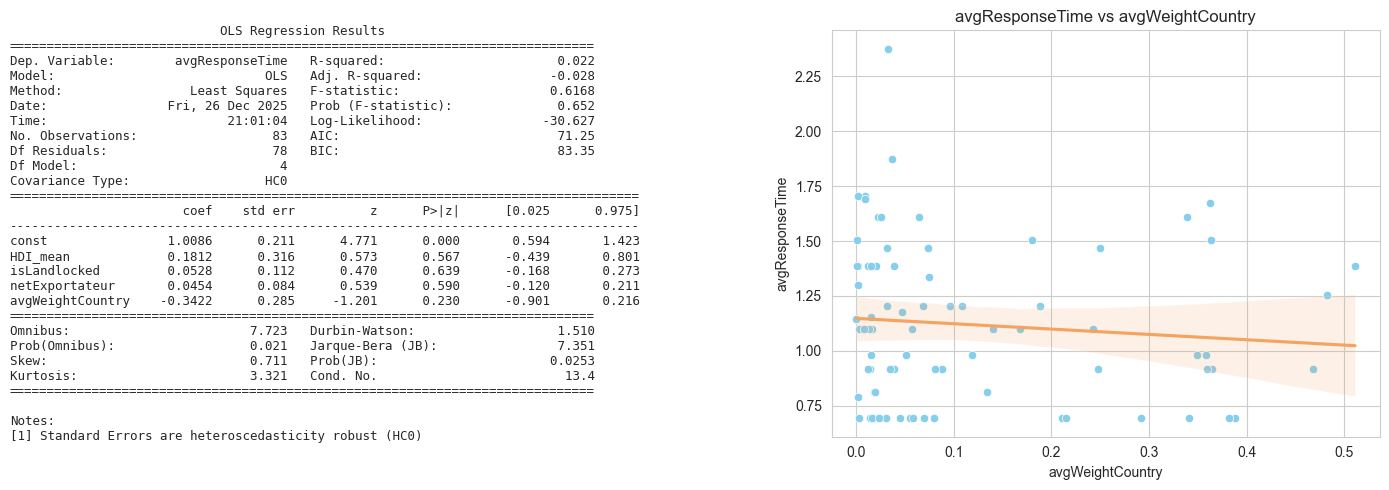

In [69]:
rg.perform_regression(dataLowPower, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC0')